# Import

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os

In [3]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D ,UpSampling2D, Input, Flatten, Dense, Dropout

# Load Data

In [4]:
def show_img(dataset):
    f, ax = plt.subplots(1,5)
    f.set_size_inches(40, 20)
    for i in range(5,10):
        ax[i-5].imshow(dataset[i].reshape(128,128), cmap='gray')
    plt.show()

In [5]:
X_train = np.load("brain_tumor/X_train.npy")
X_val = np.load("brain_tumor/X_val.npy")

## Adding Noise

In [6]:
def noise(img):
    noise_factor = 0.2
    noisy = img + noise_factor * np.random.normal(size=img.shape)
    return np.clip(noisy, 0,1)

In [7]:
def addNoise(images):
    noisy_images = []
    for img in images:
        noisy = noise(img)
        noisy_images.append(noisy)
    return np.array(noisy_images)

In [8]:
noisy_train = addNoise(X_train)
noisy_val = addNoise(X_val)

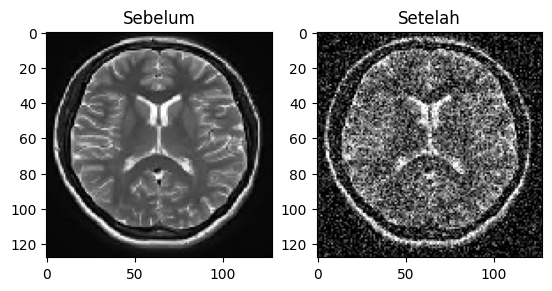

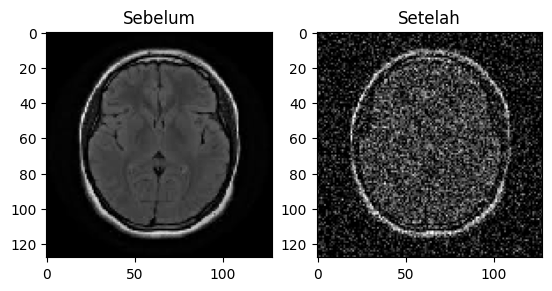

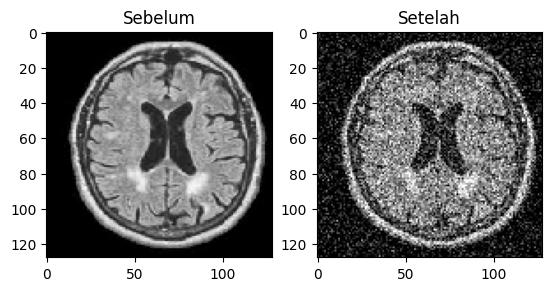

In [9]:
n = 3
for i in range (n):
  plt.subplot(121)
  plt.title("Sebelum")
  plt.imshow(tf.squeeze(X_train[i]), cmap="gray")
  plt.subplot(122)
  plt.title("Setelah")
  plt.imshow(tf.squeeze(noisy_train[i]), cmap="gray")
  plt.show()

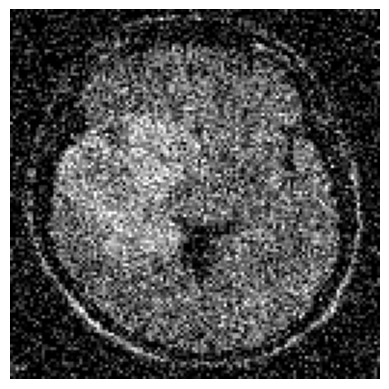

In [10]:
i = 1
for img in noisy_train:
    plt.imshow(img)
    plt.set_cmap('gray')
    plt.axis('off')
    plt.savefig('brain_tumor/training/noisy/noisy_train-'+str(i)+'.png', bbox_inches='tight', pad_inches=0)
    i = i +1

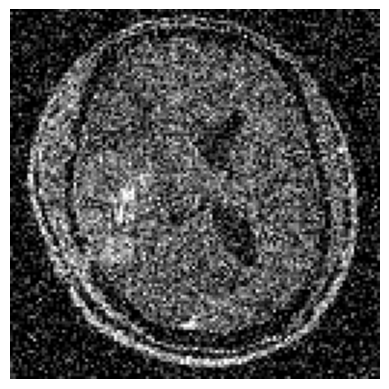

In [11]:
i = 1
for img in noisy_val:
    plt.imshow(img)
    plt.set_cmap('gray')
    plt.axis('off')
    plt.savefig('brain_tumor/validation/noisy/noisy_val-'+str(i)+'.png', bbox_inches='tight', pad_inches=0)
    i = i +1

# Denoising Autoencoder

## Architecture

In [12]:
input_image = Input(shape=(128, 128, 1)) 

In [13]:
def encoder(input_image):
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_image)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    return x

In [14]:
def decoder(input_image):
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_image)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
    return x

In [15]:
autoencoder = Model(input_image, decoder(encoder(input_image)))
autoencoder.compile(optimizer='adam' , loss='mean_squared_error')

In [16]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 64)      640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 64)        36928 

In [17]:
history = autoencoder.fit(noisy_train, X_train, epochs=100, batch_size=16, validation_data=(noisy_val, X_val))

Epoch 1/100
13/13 [==============================] - 8s 109ms/step - loss: 0.0831 - val_loss: 0.0414
Epoch 2/100
13/13 [==============================] - 0s 31ms/step - loss: 0.0300 - val_loss: 0.0275
Epoch 3/100
13/13 [==============================] - 0s 31ms/step - loss: 0.0236 - val_loss: 0.0212
Epoch 4/100
13/13 [==============================] - 0s 31ms/step - loss: 0.0179 - val_loss: 0.0159
Epoch 5/100
13/13 [==============================] - 0s 31ms/step - loss: 0.0141 - val_loss: 0.0143
Epoch 6/100
13/13 [==============================] - 0s 31ms/step - loss: 0.0127 - val_loss: 0.0140
Epoch 7/100
13/13 [==============================] - 0s 31ms/step - loss: 0.0125 - val_loss: 0.0135
Epoch 8/100
13/13 [==============================] - 0s 31ms/step - loss: 0.0117 - val_loss: 0.0125
Epoch 9/100
13/13 [==============================] - 0s 31ms/step - loss: 0.0112 - val_loss: 0.0118
Epoch 10/100
13/13 [==============================] - 0s 31ms/step - loss: 0.0107 - val_loss: 0.011

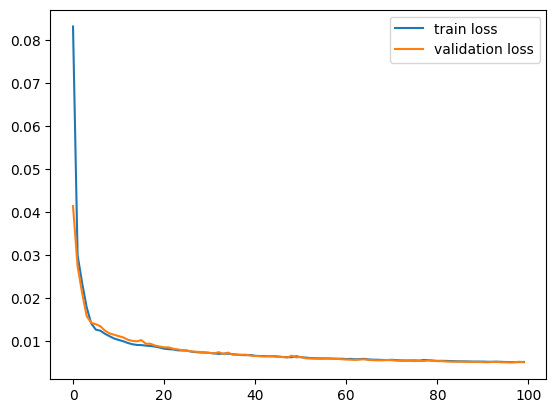

In [18]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.legend()
plt.show()

In [19]:
autoencoder.save('autoencoder.h5')